# Analysis code for Clickstream data on distance

#### Setup Code

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

In [ ]:
import jax
import jax.numpy as jnp
import jax.random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro import plate
import arviz as az

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_theme(style='whitegrid')

palette = 'coolwarm'
colors = sns.color_palette(palette, 4)
color_map = {'v1': colors[1], 'v2': colors[0], 'v3': colors[2], 'v4': colors[3]}
sns.color_palette([colors[1], colors[0], colors[2], colors[3]])

[(0.753610618, 0.830232851, 0.960871157),
 (0.48385432959999997, 0.6220498496, 0.9748082026),
 (0.9473454036, 0.7946955048, 0.7169905058),
 (0.9318312966, 0.5190855232, 0.4064796086)]

[(0.42852192568663816, 0.6022859457022, 0.7307907632583843),
 (0.9020198584978432, 0.5835085280732535, 0.6070382118908446)]

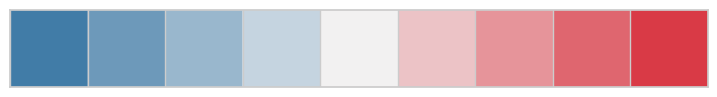

In [3]:
colors_exp = sns.palplot(sns.diverging_palette(240, 10, n=9))
# get the third color
c1 = color_exp = sns.diverging_palette(240, 10, n=9)[1]
c2 = color_exp = sns.diverging_palette(240, 10, n=9)[6]
sns.color_palette([c1, c2])

In [4]:
plt.rcParams.update({
    'font.size': 16,            # Global font size
    'axes.titlesize': 16,       # Font size of the title
    'axes.labelsize': 16,       # Font size of the x and y labels
    'xtick.labelsize': 16,      # Font size of the x tick labels
    'ytick.labelsize': 16,      # Font size of the y tick labels
    'legend.fontsize': 14,      # Font size of the legend
    'figure.titlesize': 20,     # Font size of the figure title
    'axes.titleweight': 'normal', # Weight of the title
    'axes.labelweight': 'normal', # Weight of the labels
    'axes.titlepad': 16,        # Padding between the axes and title
    'axes.labelpad': 8         # Padding between the axes and labels
})

In [5]:
plot_names = {
    "v1": "Short\nText",
    "v2": "Short\n2-Phase",
    "v3": "Long\nText",
    "v4": "Long\n2-Phase"
}

plot_oneline_names = {
    "v1": "Short Text",
    "v2": "Short 2-Phase",
    "v3": "Long Text",
    "v4": "Long 2-Phase"
}

short_names = {
    "v1": "ST",
    "v2": "S2P",
    "v3": "LT",
    "v4": "L2P"
}

### paths

In [12]:
root = './'
path = root + "/img/dist"

# Distance analysis
In this notebook we exaime three different aspects of distance participants traversed for each option.

In [13]:
voting_combined_data = pd.read_csv(root + '/data/voting_combined_data_public.csv')

In [14]:
distance_per_option = voting_combined_data.copy()

# Prepare data: Absolute value of `distance_diff`, grouped and summed
distance_per_option['distance_diff'] = distance_per_option['distance_diff'].abs()
distance_per_option = (
    distance_per_option
    .groupby(['version_id', 'user_id', 'option_id'])['distance_diff']
    .sum()
    .reset_index()
)

distance_per_option.head()

,version_id,user_id,option_id,distance_diff
0,v1,S003,option_1,3.0
1,v1,S003,option_11,4.0
2,v1,S003,option_15,5.0
3,v1,S003,option_21,3.0
4,v1,S003,option_4,3.0


In [15]:
# group by user_id to get the number of options per user
options_per_user = (
    distance_per_option
    .groupby(['version_id', 'user_id'])
    .size()
    .reset_index(name='num_options')
)
options_per_user.head()

,version_id,user_id,num_options
0,v1,S003,6
1,v1,S007,3
2,v1,S012,6
3,v1,S014,3
4,v1,S018,6


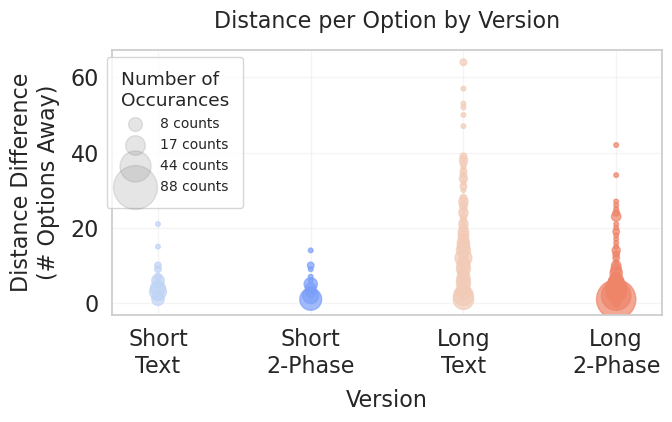

In [16]:
grouped_data = distance_per_option.groupby(['version_id', 'distance_diff']).size().reset_index(name='count')

# Normalize counts to scale circle sizes
max_count = grouped_data['count'].max()
grouped_data['size'] = grouped_data['count'] / max_count * 800  # Scale for circle sizes

# Map version_id to the color names in the dataset
grouped_data['color'] = grouped_data['version_id'].map(color_map)

# Create the bubble plot
plt.figure(figsize=(7, 4.5))
for version_id in grouped_data['version_id'].unique():
    subset = grouped_data[grouped_data['version_id'] == version_id]
    plt.scatter(
        subset['version_id'],
        subset['distance_diff'],
        s=subset['size'],
        c=subset['color'],
        alpha=0.7,
        label=plot_names[version_id]  # Label versions for internal use
    )

# Customize the x-ticks with the version names
plt.xticks(
    ticks=np.unique(distance_per_option['version_id']),
    labels=[plot_names[v] for v in np.unique(distance_per_option['version_id'])]
)

# Add a custom legend for bubble sizes
handles = [
    plt.scatter([], [], s=size, color='gray', alpha=0.2, label=f'{int(size / 800 * max_count)} counts')
    for size in [100, 200, 500, 1000]  # Example sizes
]
plt.legend(
    handles=handles,
    title='Number of\nOccurances',
    title_fontsize='small',
    # make it left left side of the plot
    bbox_to_anchor=(0.25, 1),
    # make the legend box bigger
    borderpad=1,
    # font size of the legend
    fontsize=10,
)

plt.margins(x=0.1)  # Add 10% margin on both sides of the x-axis

# Customize the plot
plt.title('Distance per Option by Version')
plt.xlabel('Version')
plt.ylabel('Distance Difference\n(# Options Away)')
plt.grid(alpha=0.2)
plt.tight_layout()

# save plot to pdf under path
plt.savefig(f'{path}/distance_diff_by_version.pdf', format='pdf', bbox_inches='tight')
# save as png
plt.savefig(f'{path}/distance_diff_by_version.png', format='png', bbox_inches='tight')

plt.show()


/tmp/ipykernel_19343/1122567266.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


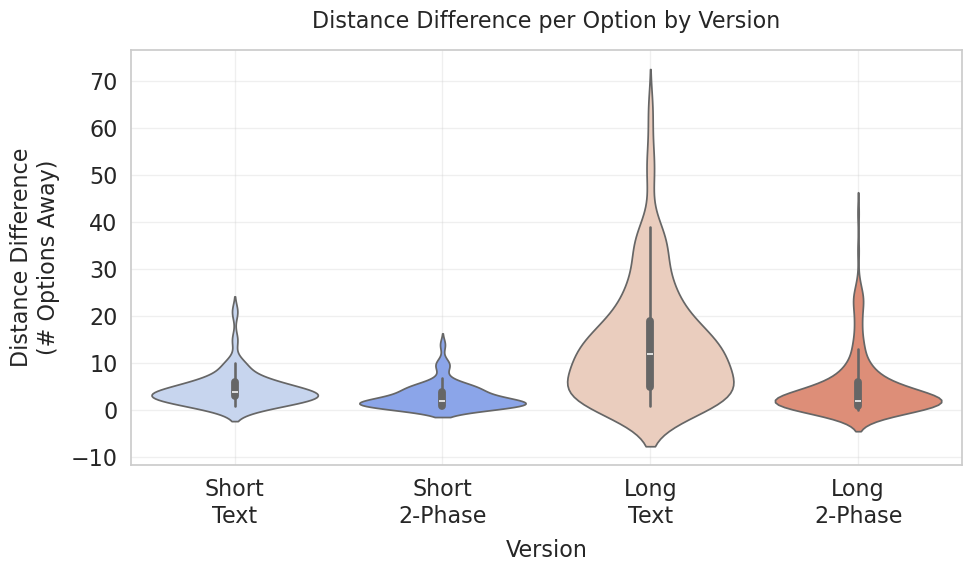

In [17]:
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=distance_per_option,
    x='version_id',
    y='distance_diff',
    palette=[color_map[f"{v}"] for v in sorted(distance_per_option['version_id'].unique())]
)

# Customize the x-ticks with the descriptive names from plot_names
plt.xticks(
    ticks=range(len(plot_names)),  # Assuming version IDs are sequential integers
    labels=[plot_names[f"{v}"] for v in sorted(distance_per_option['version_id'].unique())]
)

# Customize the plot
plt.title('Distance Difference per Option by Version')
plt.xlabel('Version')
plt.ylabel('Distance Difference\n(# Options Away)')
plt.grid(alpha=0.3)
plt.tight_layout()

# save plot to pdf under path
plt.savefig(f'{path}/distance_diff_by_version_violin.pdf', format='pdf', bbox_inches='tight')

plt.show()



In [ ]:
# Map versions and users to numerical values
version_mapping = {"v1": 1, "v2": 2, "v3": 3, "v4": 4}
distance_per_option['version_id'] = distance_per_option['version_id'].map(version_mapping)

user_mapping = {user: i for i, user in enumerate(distance_per_option['user_id'].unique())}
distance_per_option['user_id'] = distance_per_option['user_id'].map(user_mapping)

# Convert version_id and user_id to arrays
version_id = jnp.array(distance_per_option['version_id'].astype(int))
user_id = jnp.array(distance_per_option['user_id'].astype(int))

# Map versions to short/long and static/interactive
# v1 and v2 are short; v3 and v4 are long
# v1 and v3 are static; v2 and v4 are interactive
length_mapping = {1: 0, 2: 0, 3: 1, 4: 1}      # 0: short, 1: long
interface_mapping = {1: 0, 2: 1, 3: 0, 4: 1}   # 0: static, 1: interactive

length_id = jnp.array([length_mapping[v] for v in distance_per_option['version_id']])
interface_id = jnp.array([interface_mapping[v] for v in distance_per_option['version_id']])

# Convert distance_diff to array
distance_diff = jnp.array(distance_per_option['distance_diff'])

# Ensure IDs are zero-indexed integers
length_id = length_id.astype(int)
interface_id = interface_id.astype(int)
user_id = user_id.astype(int)

# Compute the number of unique categories outside the model
n_lengths = int(jnp.max(length_id).item()) + 1
n_interfaces = int(jnp.max(interface_id).item()) + 1
n_users = int(jnp.max(user_id).item()) + 1


In [20]:
def distance_model(
    length_id, interface_id, user_id,
    n_lengths, n_interfaces, n_users,
    distance_diff=None
):
    # --- Hyperpriors for Length Effects ---
    mu_length = numpyro.sample("mu_length", dist.Normal(0, 1))  # Global intercept for length
    beta_length = numpyro.sample("beta_length", dist.Normal(0, 1))  # Slope for ordinal length

    # Compute length effect as a linear function of length_id
    length_effect = mu_length + beta_length * length_id
    
    # --- Hyperpriors for Interface Effects ---
    mu_interface = numpyro.sample("mu_interface", dist.Normal(0, 1))
    sigma_interface = numpyro.sample("sigma_interface", dist.HalfNormal(0.5))  # Exponential prior
    
    # Non-centered parameterization for Interface Effects
    interface_effect_raw = numpyro.sample(
        "interface_effect_raw",
        dist.Normal(0, 1).expand([n_interfaces])
    )
    interface_effect = numpyro.deterministic(
        "interface_effect",
        mu_interface + interface_effect_raw * sigma_interface
    )
    
    # --- Hyperpriors for Interaction Effects ---
    num_length_levels = n_lengths
    num_interface_levels = n_interfaces
    
    # LKJ prior on the correlation matrix for interactions
    eta = 3  # Shape parameter for LKJ, increased for more concentration
    L_Omega = numpyro.sample(
        "L_Omega",
        dist.LKJCholesky(num_interface_levels, eta)
    )
    
    # Sample standard deviations for interaction effects per interface level
    sigma_interaction = numpyro.sample(
        "sigma_interaction",
        dist.HalfNormal(0.5).expand([num_length_levels, num_interface_levels])  # Exponential prior
    )
    
    # Non-centered parameterization: z_interaction as a matrix
    z_interaction = numpyro.sample(
        "z_interaction",
        dist.Normal(0, 1).expand([num_length_levels, num_interface_levels])
    )

    # Compute interaction effects
    interaction_covariance = jnp.einsum('jk,ik->ij', L_Omega, z_interaction)
    interaction_effect = interaction_covariance * sigma_interaction  # Shape: [i, j]

    # --- Hyperpriors for User Effects ---
    mu_user = numpyro.sample("mu_user", dist.Normal(0, 1))
    sigma_user = numpyro.sample("sigma_user", dist.Exponential(0.5))  # Exponential prior
    
    # User effects using plate
    with numpyro.plate("users", n_users):
        user_raw = numpyro.sample("user_raw", dist.Normal(0, 1))
        user_effect = mu_user + sigma_user * user_raw
    
    # --- Linear Predictor ---
    # Directly index interaction_effect using length_id and interface_id
    log_scale_obs = (
        length_effect +
        interface_effect[interface_id] +
        interaction_effect[length_id, interface_id] +
        user_effect[user_id]
    )
    scale_obs = jnp.exp(log_scale_obs)
    
    # --- Likelihood ---
    numpyro.sample("obs", dist.Exponential(scale_obs), obs=distance_diff)

In [21]:
# Run the MCMC
kernel = NUTS(distance_model, target_accept_prob=0.9)
mcmc = MCMC(kernel, num_warmup=3000, num_samples=1500, num_chains=2)
mcmc.run(
    jax.random.PRNGKey(0),
    length_id=length_id,
    interface_id=interface_id,
    user_id=user_id,
    n_lengths=n_lengths,
    n_interfaces=n_interfaces,
    n_users=n_users,
    distance_diff=distance_diff
)

# Get the posterior samples
mcmc_samples = mcmc.get_samples()

# Print summary
mcmc.print_summary()

/tmp/ipykernel_19343/3203120142.py:3: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=3000, num_samples=1500, num_chains=2)


sample: 100%|██████████| 4500/4500 [00:10<00:00, 442.74it/s, 127 steps of size 2.46e-02. acc. prob=0.95]



                             mean       std    median      5.0%     95.0%     n_eff     r_hat
           L_Omega[0,0]      1.00      0.00      1.00      1.00      1.00       nan       nan
           L_Omega[0,1]      0.00      0.00      0.00      0.00      0.00       nan       nan
           L_Omega[1,0]     -0.01      0.37     -0.00     -0.65      0.55   2625.62      1.00
           L_Omega[1,1]      0.92      0.10      0.96      0.80      1.00   1641.71      1.00
            beta_length     -0.65      0.43     -0.66     -1.33      0.06    919.64      1.00
interface_effect_raw[0]     -0.54      0.88     -0.55     -1.95      0.90   1825.44      1.00
interface_effect_raw[1]      0.43      0.89      0.43     -0.95      1.95   2146.85      1.00
           mu_interface     -0.46      0.82     -0.44     -1.84      0.79   2042.25      1.00
              mu_length     -0.41      0.83     -0.41     -1.80      0.90   1757.21      1.00
                mu_user     -0.44      0.83     -0.46     -

In [ ]:
from numpyro.infer import Predictive

# Define the Predictive object
predictive = Predictive(
    distance_model,
    posterior_samples=mcmc_samples,
    num_samples=3000  # Adjust based on computational resources
)

# Generate posterior predictive samples
posterior_predictive = predictive(
    jax.random.PRNGKey(0),
    length_id=length_id,
    interface_id=interface_id,
    user_id=user_id,
    n_lengths=n_lengths,
    n_interfaces=n_interfaces,
    n_users=n_users,
    distance_diff=None  # Set to None to generate new 'obs' samples
)

posterior = az.from_numpyro(mcmc)


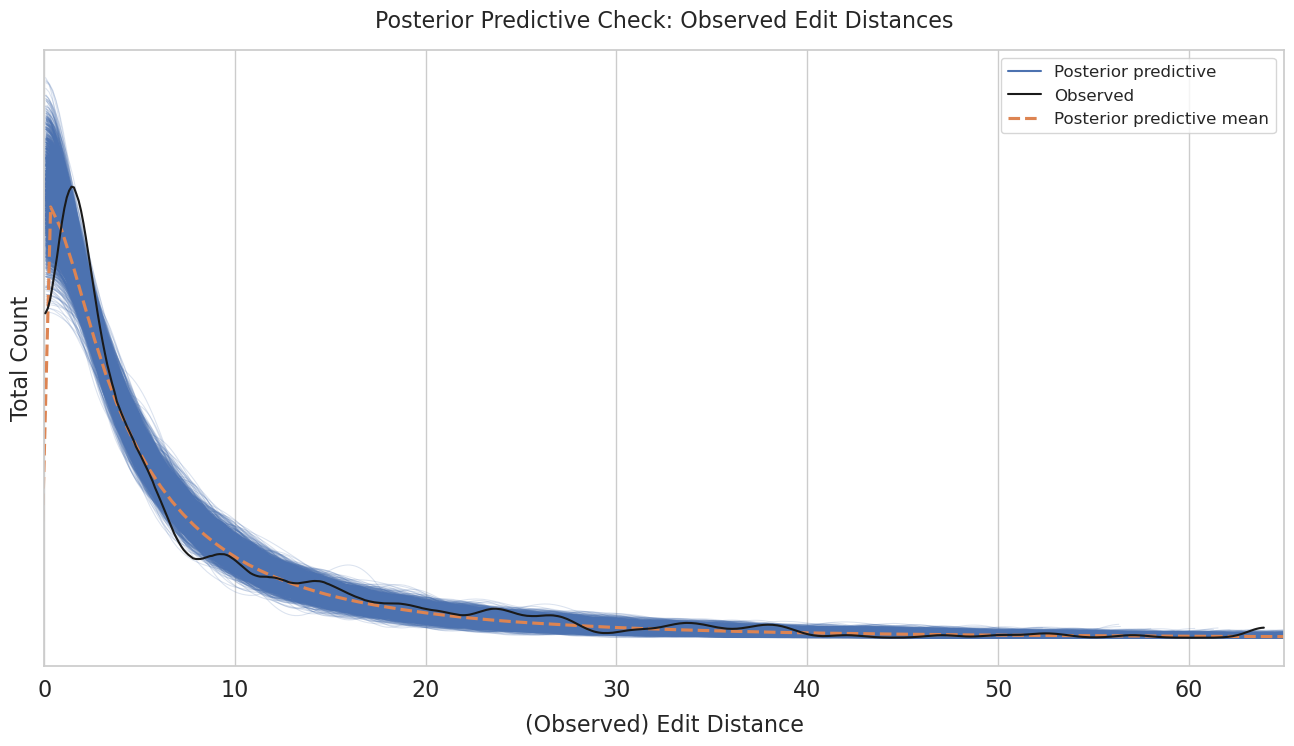

In [23]:
# Perform Posterior Predictive Checks
ppc = az.from_numpyro(mcmc, posterior_predictive=posterior_predictive)

fig, ax = plt.subplots(figsize=(16, 8))  # Adjust width and height as needed
az.plot_ppc(ppc, ax=ax)

ax.set_xlabel("(Observed) Edit Distance")
ax.set_ylabel("Total Count")
ax.set_title("Posterior Predictive Check: Observed Edit Distances")

# Limit the y-axis to avoid the long tail
plt.xlim(0, 65)  # Adjust this range based on your data
# save the plot
plt.savefig(f'{path}/ppc_distance_m1.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [25]:
versions = ["v1", "v2", "v3", "v4"]

# Initialize a dictionary to store aggregated predictions per version
aggregated_predictions = {}

for version in versions:
    # Step 1: Get the numerical version ID
    version_num = version_mapping[version]
    
    # Step 2: Retrieve the corresponding length_id and interface_id
    length = length_mapping[version_num]
    interface = interface_mapping[version_num]
    
    # Find indices where length_id and interface_id match the current version
    version_indices = (length_id == length) & (interface_id == interface)
    
    # Check if there are observations for this version
    if not np.any(version_indices):
        raise ValueError(f"No observations found for version {version} with length_id={length} and interface_id={interface}.")
    
    # Extract posterior predictive samples for these observations
    # Shape: [n_samples, n_version_observations]
    post_pred_version = posterior_predictive['obs'][:, version_indices]
    
    # Aggregate by taking the mean across observations for each sample
    # Resulting shape: [n_samples]
    mean_post_pred_version = np.mean(post_pred_version, axis=1)
    
    # Store in the dictionary
    aggregated_predictions[version] = mean_post_pred_version

# Compute overall means to decide which version is bigger
overall_means = {version: np.mean(aggregated_predictions[version]) for version in versions}


In [26]:
# Initialize a dictionary to store pairwise differences
pairwise_differences = {}

for i in range(len(versions)):
    for j in range(i + 1, len(versions)):
        if (i == 1 and j == 2) or (i == 0 and j == 3): continue

        version_i = versions[i]
        version_j = versions[j]
        
        mean_i = overall_means[version_i]
        mean_j = overall_means[version_j]
        
        # Determine which version is bigger based on overall mean
        if mean_j >= mean_i:
            bigger = version_j
            smaller = version_i
        else:
            bigger = version_i
            smaller = version_j
        
        # Compute the difference: bigger - smaller
        diff = aggregated_predictions[bigger] - aggregated_predictions[smaller]
        
        # Create a descriptive label
        label = f"{plot_oneline_names[bigger]} vs.\n{plot_oneline_names[smaller]}"
        pairwise_differences[label] = diff

# Prepare data for ArviZ
# ArviZ expects [chains, draws, ...]. Assuming a single chain:
for label in pairwise_differences:
    pairwise_differences[label] = pairwise_differences[label].reshape(1, -1)

# Convert to InferenceData
idata_diff = az.from_dict(posterior=pairwise_differences)

In [27]:
# get the summary of the differences
az.summary(idata_diff)

arviz - WARNING - Shape validation failed: input_shape: (1, 3000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Long 2-Phase vs.\nShort 2-Phase,1.795,0.822,0.268,3.365,0.016,0.011,2814.0,2812.0,NaN
Long Text vs.\nLong 2-Phase,9.065,1.566,6.132,11.967,0.029,0.020,2979.0,2793.0,NaN
Long Text vs.\nShort Text,9.312,1.818,6.014,12.831,0.034,0.024,2795.0,2574.0,NaN
Short Text vs.\nShort 2-Phase,1.548,1.201,-0.703,3.850,0.021,0.016,3144.0,2894.0,NaN


In [28]:
# Compute effect sizes (difference / standard deviation of each sample)
effect_sizes = {}
for label, samples in pairwise_differences.items():
    std_dev = np.std(samples, axis=1, keepdims=True)  # Compute standard deviation
    effect_sizes[label] = samples / std_dev  # Standardized difference
    effect_sizes[label] = effect_sizes[label].reshape(1, -1)  # Ensure correct shape
# Create a new InferenceData object for effect sizes
idata_effect_sizes = az.from_dict(posterior=effect_sizes)


In [29]:
# Validate the desired order matches the keys in idata_diff
desired_order = ["Long Text vs.\nShort Text", "Long 2-Phase vs.\nShort 2-Phase", "Short Text vs.\nShort 2-Phase", "Long Text vs.\nLong 2-Phase"]

for label in desired_order:
    if label not in pairwise_differences:
        raise ValueError(f"The label '{label}' is not found in the pairwise differences.")

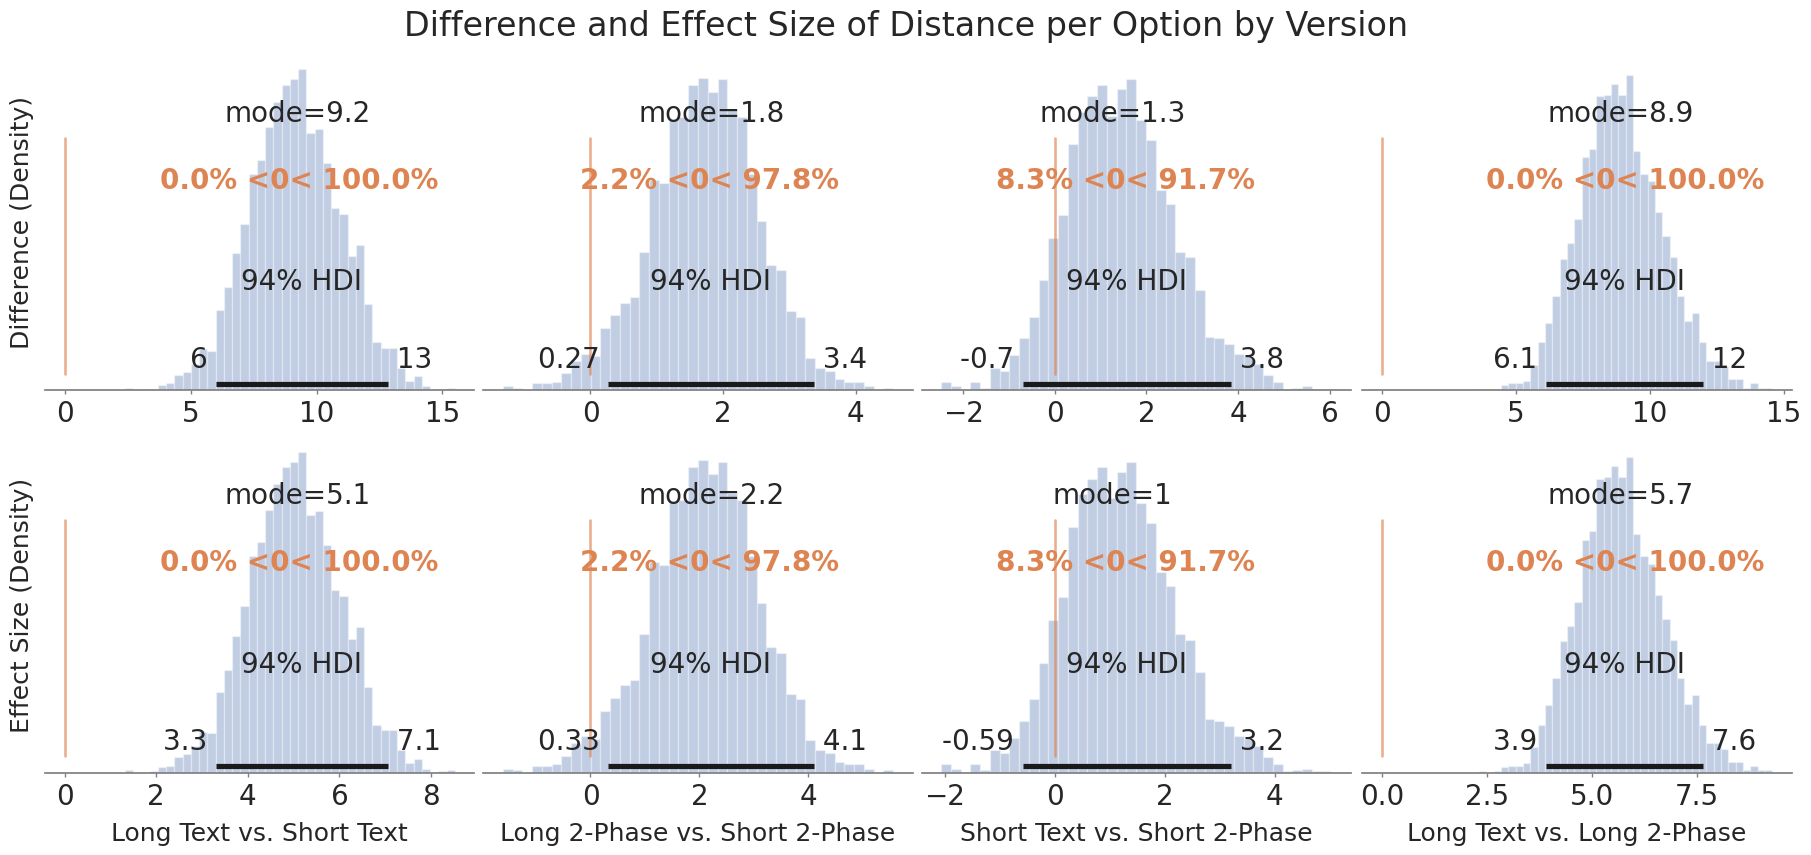

In [30]:
# Prepare figure layout for the two rows
n_cols = len(desired_order)  # Number of comparisons
fig, axes = plt.subplots(
    2, n_cols, figsize=(18, 8), sharey='row', constrained_layout=True
)

# Define histogram bin size
bin_size = 40

# Create plots for the first row (difference plots)
for i, label in enumerate(desired_order):
    az.plot_posterior(
        idata_diff,
        var_names=[label],
        ax=axes[0, i],
        hdi_prob=0.94,
        point_estimate="mode",
        ref_val=0,
        kind="hist",
        bins=bin_size,
        textsize=20,
    )
    
    axes[0, i].set_title("", fontsize=18)
    axes[0, i].grid(axis="x", linestyle="", alpha=0.6)  # X-axis grid lines only
    axes[0, i].grid(axis="y", linestyle="", alpha=0.0)    # No Y-axis grid lines

# Create plots for the second row (effect size plots)
for i, label in enumerate(desired_order):
    az.plot_posterior(
        idata_effect_sizes,
        var_names=[label],
        ax=axes[1, i],
        hdi_prob=0.94,
        point_estimate="mode",
        ref_val=0,
        kind="hist",
        bins=bin_size,
        textsize=20,
    )
    axes[1, i].set_title("")
    axes[1, i].grid(axis="x", linestyle="", alpha=0.6)  # X-axis grid lines only
    axes[1, i].grid(axis="y", linestyle="", alpha=0.0)    # No Y-axis grid lines

# Adjust labels and layout
axes[0, 0].set_ylabel("Difference (Density)", fontsize=18)
axes[1, 0].set_ylabel("Effect Size (Density)", fontsize=18)
# set the x-axis label for the last row of plots with the version names
for i in range(n_cols):
    axes[1, i].set_xlabel(desired_order[i].replace('\n', " "), fontsize=18)


# set plt title
plt.suptitle("Difference and Effect Size of Distance per Option by Version", fontsize=24, y=1.05)


plt.savefig(f'{path}/distance_diff_per_option_effect_size_by_version.pdf', format='pdf', bbox_inches='tight')
plt.show()

### Next we look at per action distance traversed by participants

In [32]:
voting_combined_data = pd.read_csv(root + '/data/voting_combined_data_public.csv')

In [33]:
# Ensure voting_combined_data exists
distance_per_option = voting_combined_data.copy()

# Prepare data: Absolute value of `distance_diff`, grouped and summed
distance_per_option['distance_diff'] = distance_per_option['distance_diff'].abs()
distance_per_option = (
    distance_per_option
    .groupby(['version_id', 'user_id', 'option_id'])['distance_diff']
    .sum()
    .reset_index()
)

distance_per_option

,version_id,user_id,option_id,distance_diff
0,v1,S003,option_1,3.0
1,v1,S003,option_11,4.0
2,v1,S003,option_15,5.0
3,v1,S003,option_21,3.0
4,v1,S003,option_4,3.0
...,...,...,...,...
541,v4,S039,option_30,6.0
542,v4,S039,option_31,6.0
543,v4,S039,option_7,2.0
544,v4,S039,option_8,8.0


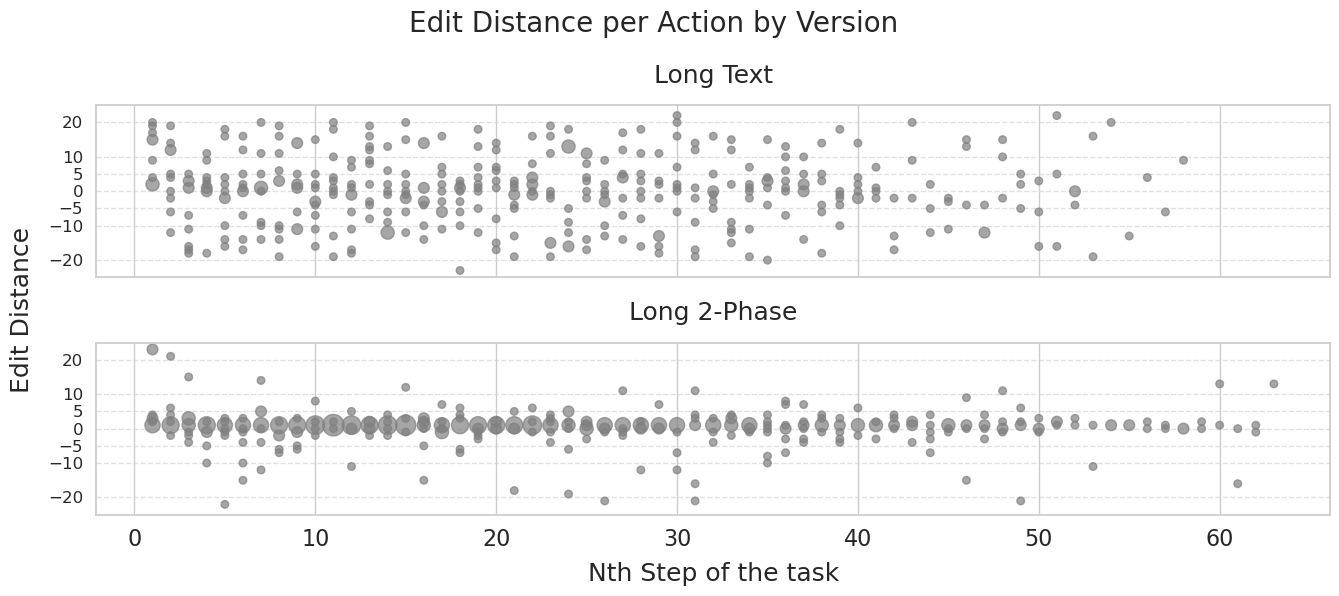

In [34]:
# Create subplots for a 2x1 layout
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 6), sharex=True)

# Group version IDs
version_ids = ["v3", "v4"]

# Iterate through the versions and plot
for ax, version_id in zip(axes, version_ids):
    # Filter data for the current version
    group_data = voting_combined_data[voting_combined_data["version_id"] == version_id]
    
    # Count occurrences for each (step, distance_diff) pair
    group_data = group_data.assign(
        step=group_data.groupby("user_id").cumcount() + 1  # Add a 'step' column
    )
    counts = group_data.groupby(["step", "distance_diff"]).size().reset_index(name="count")
    
    # Plot scatter points with radius proportional to occurrence count
    scatter = ax.scatter(
        counts["step"],  # X-axis: Steps
        counts["distance_diff"],  # Y-axis: Distance Difference
        s=counts["count"] * 30,  # Size proportional to count (adjust multiplier as needed)
        alpha=0.7,
        c='grey',  # Color set to grey
        label=f"{version_id}"
    )
    
    # Update subplot title
    ax.set_title(f"{plot_oneline_names[version_id]}", fontsize=18)
    
    # Set consistent y-axis range
    ax.set_ylim(-25, 25)
    # set ticks at 0, 5, 10, 20 with font size 12
    ax.set_yticks([-20, -10, -5, 0, 5, 10, 20])
    ax.tick_params(axis='y', labelsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.6)

# Shared x-axis label
axes[-1].set_xlabel("Nth Step of the task", fontsize=18)

# Shared y-axis label for all rows
fig.text(0.04, 0.5, "Edit Distance", va='center', rotation='vertical', fontsize=18)

# Adjust layout
plt.tight_layout(rect=[0.05, 0, 1, 0.95])  # Adjust to leave space for the suptitle

# Add the suptitle with adjusted y-position
plt.suptitle("Edit Distance per Action by Version", y=1)
plt.savefig(f'{path}/edit_distance_per_action_by_version.pdf', format='pdf', bbox_inches='tight')
plt.savefig(f'{path}/edit_distance_per_action_by_version.png', format='png', bbox_inches='tight')
plt.show()

In [35]:
# what is the mean distance difference for each version
mean_distance_per_version = distance_per_option.groupby('version_id')['distance_diff'].mean()
mean_distance_per_version

version_id
v1     4.538462
v2     3.051724
v3    14.164319
v4     5.044843
Name: distance_diff, dtype: float64

In [36]:
data = voting_combined_data.copy()

# Map `version_id` to indices for versions v1, v2, v3, v4
version_idx = jnp.array(data['version_id'].astype("category").cat.codes, dtype=jnp.int32)

# Map `user_id` to user indices
user_idx = jnp.array(data['user_id'].astype("category").cat.codes, dtype=jnp.int32)

# Step 2: Map versions to short/long and interface0/interface1
# Add columns for length_id (0 for short, 1 for long) and interface_id (0 or 1)
data["length_id"] = data["version_id"].map({"v1": 0, "v2": 0, "v3": 1, "v4": 1})  # 0: short, 1: long
data["interface_id"] = data["version_id"].map({"v1": 0, "v3": 0, "v2": 1, "v4": 1})  # 0: interface0, 1: interface1

# Convert the new columns into JAX arrays
length_id = jnp.array(data["length_id"], dtype=jnp.int32)
interface_id = jnp.array(data["interface_id"], dtype=jnp.int32)

# Step 3: Prepare distance_diff for the model
distance_diff = jnp.array(data['distance_diff'], dtype=jnp.float32)

# Step 4: Calculate dimensions for the model
n_users = len(jnp.unique(user_idx))  # Number of unique users
n_versions = len(jnp.unique(version_idx))  # Number of unique versions
n_lengths = len(jnp.unique(length_id))  # Number of unique length categories (short/long)
n_interfaces = len(jnp.unique(interface_id))  # Number of unique interface categories (interface0/interface1)

# Step 5: Verify the prepared data
print("Prepared Data:")
print("Unique Versions:", n_versions)
print("Unique Users:", n_users)
print("Unique Lengths:", n_lengths)
print("Unique Interfaces:", n_interfaces)
print("Distance diff shape:", distance_diff.shape)
print("Version index shape:", version_idx.shape)
print("User index shape:", user_idx.shape)

Prepared Data:
Unique Versions: 4
Unique Users: 40
Unique Lengths: 2
Unique Interfaces: 2
Distance diff shape: (996,)
Version index shape: (996,)
User index shape: (996,)


In [37]:
def distance_model(
    length_id, interface_id, user_id,
    n_lengths, n_interfaces, n_users,
    distance_diff=None
):
    # --- Hyperpriors for Mean Predictors ---
    # Length effects on mean (ordinal)
    mu_length_mean = numpyro.sample("mu_length_mean", dist.Normal(0, 1))  # Intercept
    beta_length_mean = numpyro.sample("beta_length_mean", dist.Normal(0, 1))  # Slope
    
    # Compute length effect for mean as ordinal
    length_effect_mean = mu_length_mean + beta_length_mean * length_id
    
    # Interface effects on mean
    mu_interface_mean = numpyro.sample("mu_interface_mean", dist.Normal(0, 1))
    sigma_interface_mean = numpyro.sample("sigma_interface_mean", dist.HalfNormal(0.5))
    interface_effect_raw_mean = numpyro.sample(
        "interface_effect_raw_mean",
        dist.Normal(0, 1).expand([n_interfaces])
    )
    interface_effect_mean = numpyro.deterministic(
        "interface_effect_mean",
        mu_interface_mean + interface_effect_raw_mean * sigma_interface_mean
    )
    
    # Interaction effects on mean
    eta_mean = 3
    L_Omega_mean = numpyro.sample(
        "L_Omega_mean",
        dist.LKJCholesky(n_interfaces, eta_mean)
    )
    sigma_interaction_mean = numpyro.sample(
        "sigma_interaction_mean",
        dist.HalfNormal(0.5).expand([n_lengths, n_interfaces])
    )
    z_interaction_mean = numpyro.sample(
        "z_interaction_mean",
        dist.Normal(0, 1).expand([n_lengths, n_interfaces])
    )
    interaction_covariance_mean = jnp.einsum('jk,ik->ij', L_Omega_mean, z_interaction_mean)
    interaction_effect_mean = interaction_covariance_mean * sigma_interaction_mean

    # User effects on mean
    mu_user_mean = numpyro.sample("mu_user_mean", dist.Normal(0, 1))
    sigma_user_mean = numpyro.sample("sigma_user_mean", dist.HalfNormal(0.5))
    with numpyro.plate("users_mean", n_users):
        user_raw_mean = numpyro.sample("user_raw_mean", dist.Normal(0, 1))
        user_effect_mean = mu_user_mean + sigma_user_mean * user_raw_mean

    # --- Linear Predictor for Mean ---
    mu = (
        length_effect_mean +
        interface_effect_mean[interface_id] +
        interaction_effect_mean[length_id, interface_id] +
        user_effect_mean[user_id]
    )

    # --- Hyperpriors for Variance Predictors ---
    # Length effects on variance (ordinal)
    mu_length_var = numpyro.sample("mu_length_var", dist.Normal(0, 1))  # Intercept
    beta_length_var = numpyro.sample("beta_length_var", dist.Normal(0, 1))  # Slope
    
    # Compute length effect for variance as ordinal
    length_effect_var = mu_length_var + beta_length_var * length_id
    
    # Interface effects on variance
    mu_interface_var = numpyro.sample("mu_interface_var", dist.Normal(0, 1))
    sigma_interface_var = numpyro.sample("sigma_interface_var", dist.HalfNormal(0.5))
    interface_effect_raw_var = numpyro.sample(
        "interface_effect_raw_var",
        dist.Normal(0, 1).expand([n_interfaces])
    )
    interface_effect_var = numpyro.deterministic(
        "interface_effect_var",
        mu_interface_var + interface_effect_raw_var * sigma_interface_var
    )
    
    # Interaction effects on variance
    eta_var = 3
    L_Omega_var = numpyro.sample(
        "L_Omega_var",
        dist.LKJCholesky(n_interfaces, eta_var)
    )
    sigma_interaction_var = numpyro.sample(
        "sigma_interaction_var",
        dist.HalfNormal(0.5).expand([n_lengths, n_interfaces])
    )
    z_interaction_var = numpyro.sample(
        "z_interaction_var",
        dist.Normal(0, 1).expand([n_lengths, n_interfaces])
    )
    interaction_covariance_var = jnp.einsum('jk,ik->ij', L_Omega_var, z_interaction_var)
    interaction_effect_var = interaction_covariance_var * sigma_interaction_var

    # User effects on variance
    mu_user_var = numpyro.sample("mu_user_var", dist.Normal(0, 1))
    sigma_user_var = numpyro.sample("sigma_user_var", dist.HalfNormal(0.5))
    with numpyro.plate("users_var", n_users):
        user_raw_var = numpyro.sample("user_raw_var", dist.Normal(0, 1))
        user_effect_var = mu_user_var + sigma_user_var * user_raw_var

    # --- Linear Predictor for Variance ---
    log_sigma_obs = (
        length_effect_var +
        interface_effect_var[interface_id] +
        interaction_effect_var[length_id, interface_id] +
        user_effect_var[user_id]
    )
    sigma_obs = jnp.exp(log_sigma_obs)  # Ensure positivity
    
    # --- Likelihood ---
    numpyro.sample("obs", dist.Normal(mu, sigma_obs), obs=distance_diff)


In [38]:
kernel = NUTS(distance_model, target_accept_prob=0.90)  # Using the model defined earlier
mcmc = MCMC(kernel, num_warmup=4000, num_samples=1500, num_chains=2)

mcmc.run(
    jax.random.PRNGKey(0),
    length_id=length_id,
    interface_id=interface_id,
    user_id=user_idx,
    n_lengths=n_lengths,
    n_interfaces=n_interfaces,
    n_users=n_users,
    distance_diff=distance_diff
)

# Step 7: Get posterior samples and print the summary
mcmc_samples = mcmc.get_samples()
mcmc.print_summary()

/tmp/ipykernel_19343/4085661647.py:2: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=4000, num_samples=1500, num_chains=2)
sample: 100%|██████████| 5500/5500 [01:14<00:00, 73.40it/s, 255 steps of size 1.30e-02. acc. prob=0.95]



                                  mean       std    median      5.0%     95.0%     n_eff     r_hat
           L_Omega_mean[0,0]      1.00      0.00      1.00      1.00      1.00       nan       nan
           L_Omega_mean[0,1]      0.00      0.00      0.00      0.00      0.00       nan       nan
           L_Omega_mean[1,0]      0.02      0.37      0.03     -0.56      0.63   3724.78      1.00
           L_Omega_mean[1,1]      0.92      0.09      0.96      0.80      1.00   1354.16      1.00
            L_Omega_var[0,0]      1.00      0.00      1.00      1.00      1.00       nan       nan
            L_Omega_var[0,1]      0.00      0.00      0.00      0.00      0.00       nan       nan
            L_Omega_var[1,0]     -0.00      0.38     -0.01     -0.67      0.59   3272.58      1.00
            L_Omega_var[1,1]      0.92      0.11      0.96      0.77      1.00   1403.95      1.00
            beta_length_mean      0.11      0.41      0.11     -0.60      0.74   2413.70      1.00
         

In [39]:
# Generate posterior predictive samples
rng_key = jax.random.PRNGKey(42)  # Set a random seed
predictive = Predictive(
    distance_model,  # Use the current model
    posterior_samples=mcmc.get_samples()
)
pred_samples = predictive(
    rng_key,
    length_id=length_id,
    interface_id=interface_id,
    user_id=user_idx,
    n_lengths=n_lengths,
    n_interfaces=n_interfaces,
    n_users=n_users,
    distance_diff=None,  # Generate new samples instead of conditioning on existing data
)

# Extract predictions for distances
pred_distances = pred_samples["obs"]  # Posterior predictive samples

# Get unique versions (groups)
version_groups = jnp.unique(version_idx)


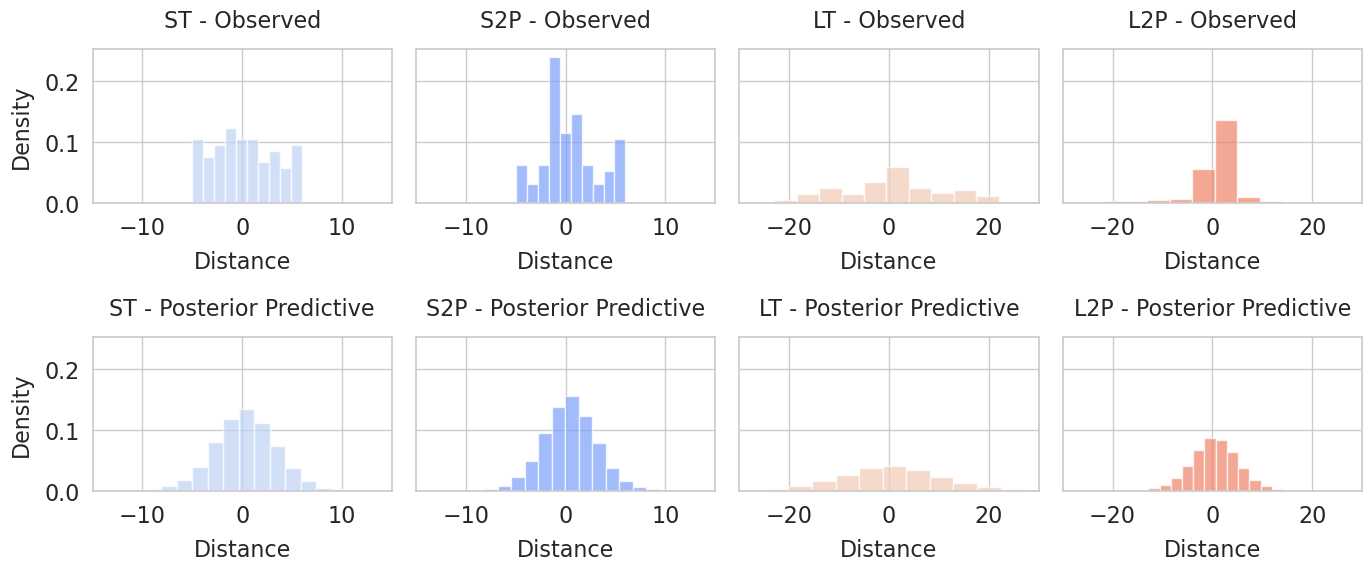

In [40]:
# Define distinct colors for each version column
observed_colors = [colors[1], colors[0], colors[2], colors[3]]  # Modify the number of colors based on the number of versions
posterior_colors = [colors[1], colors[0], colors[2], colors[3]]

fig, axes = plt.subplots(2, len(version_groups), figsize=(14, 6), sharey=True) #sharex

for i, version in enumerate(version_groups):
    if i < 2:
        x_limits = (-15, 15)
    else:
        x_limits = (-30, 30)
    
    axes[0, i].set_xlim(x_limits)
    axes[1, i].set_xlim(x_limits)

    # Subset predictions and observations for the current group
    version_mask = version_idx == version
    group_obs = distance_diff[version_mask]  # Observed distances for this group
    group_preds = pred_distances[:, version_mask]  # Predicted distances for this group

    # Randomly downsample posterior draws for visualization
    rng_key, subkey = jax.random.split(rng_key)
    subset_indices = jax.random.choice(
        subkey,
        group_preds.shape[0],  # Number of posterior draws
        shape=(200,),  # Choose a manageable number of samples
        replace=False,
    )
    sampled_posterior = group_preds[subset_indices, :].flatten()

    # Plot observed data histogram (Top Row)
    axes[0, i].hist(
        group_obs,
        bins=10,
        alpha=0.7,
        color=observed_colors[i % len(observed_colors)],  # Assign unique color
        label="Observed",
        density=True,
    )
    axes[0, i].set_title(f"{short_names['v'+str(i+1)]} - Observed")
    axes[0, i].set_xlabel("Distance")
    if i == 0:
        axes[0, i].set_ylabel("Density")
    # axes[0, i].legend()

    # Plot posterior predictive histogram (Bottom Row)
    axes[1, i].hist(
        sampled_posterior,
        bins=20,
        alpha=0.7,
        color=posterior_colors[i % len(posterior_colors)],  # Assign unique color
        label="Posterior Predictive",
        density=True,
    )
    axes[1, i].set_title(f"{short_names['v'+str(i+1)]} - Posterior Predictive")
    axes[1, i].set_xlabel("Distance")
    if i == 0:
        axes[1, i].set_ylabel("Density")
    # axes[1, i].legend()

    # set the first two exis to be between -20 and 20 and the latter 40 -40


# Adjust layout and display
plt.tight_layout()
plt.savefig(f'{path}/observed_vs_posterior_predictive_histogram_m2.pdf', format='pdf', bbox_inches='tight')
# save as png
plt.savefig(f'{path}/observed_vs_posterior_predictive_histogram_m2.png', format='png', bbox_inches='tight')
plt.show()


In [41]:
# 1. Aggregate posterior predictive samples by version
unique_versions = jnp.unique(version_idx)
aggregated_variances = {}

for version in unique_versions:
    version_mask = version_idx == version
    version_preds = pred_samples["obs"][:, version_mask]  # Shape: [n_samples, n_observations_per_version]
    
    # Calculate the variance across observations for each sample
    variance_version_preds = version_preds.var(axis=1)  # Shape: [n_samples]
    aggregated_variances[f"v{int(version)}"] = variance_version_preds

# 2. Compute pairwise variance differences and effect sizes
pairwise_variance_differences = {}
pairwise_effect_sizes = {}

for i in range(len(unique_versions)):
    for j in range(i + 1, len(unique_versions)):
        version_i = f"v{int(unique_versions[i])}"
        version_j = f"v{int(unique_versions[j])}"
        
        # Compute mean variances to decide the order of subtraction
        mean_variance_i = aggregated_variances[version_i].mean()
        mean_variance_j = aggregated_variances[version_j].mean()
        
        if mean_variance_j >= mean_variance_i:
            larger, smaller = version_j, version_i
        else:
            larger, smaller = version_i, version_j
        
        # Compute the variance difference: larger - smaller
        variance_diff = aggregated_variances[larger] - aggregated_variances[smaller]
        pairwise_variance_differences[f"{larger} vs {smaller}"] = variance_diff
        
        # Compute effect size for each posterior sample
        effect_size = variance_diff / np.std(variance_diff)
        pairwise_effect_sizes[f"{larger} vs {smaller}"] = effect_size

# 3. Convert pairwise variance differences to InferenceData
for label in pairwise_variance_differences:
    pairwise_variance_differences[label] = pairwise_variance_differences[label][np.newaxis, :]  # Add chain dimension

idata_var_diff = az.from_dict(posterior=pairwise_variance_differences)

# 4. Convert pairwise effect sizes to InferenceData
for label in pairwise_effect_sizes:
    pairwise_effect_sizes[label] = pairwise_effect_sizes[label][np.newaxis, :]  # Add chain dimension

idata_effect_sizes = az.from_dict(posterior=pairwise_effect_sizes)


In [42]:
# count the number of occurrences for each version_idx
version_counts = np.bincount(version_idx)
display(version_counts)
pairwise_variance_differences.keys()

array([ 96,  87, 391, 422])

dict_keys(['v0 vs v1', 'v2 vs v0', 'v3 vs v0', 'v2 vs v1', 'v3 vs v1', 'v2 vs v3'])

In [43]:
# only keep v0, v1; v2, v3
desired_order = ["v0 vs v1", "v2 vs v3"]
order_label = {
    "v0 vs v1": "Short Text vs\nShort 2-Phase",
    "v2 vs v3": "Long Text vs\nLong 2-Phase",
}

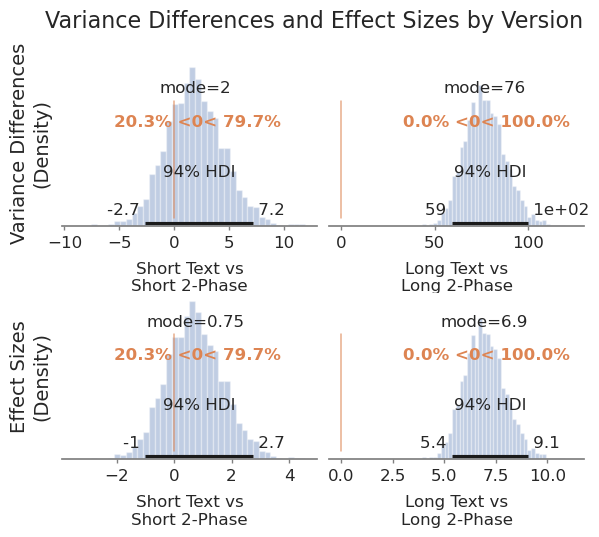

In [44]:
# Step 1: Create subplots without constrained_layout
fig, axes = plt.subplots(
    2, 
    len(desired_order), 
    figsize=(6, 5), 
    sharey=True
)

bin_size = 40

for i, label in enumerate(desired_order):
    # Row 0: Variance Differences
    az.plot_posterior(
        idata_var_diff,
        var_names=[label],
        ax=axes[0, i],      # Top row for variance differences
        hdi_prob=0.94,
        point_estimate="mode",
        ref_val=0,
        kind="hist",
        bins=bin_size,
        textsize=12,
        show=False
    )
    axes[0, i].set_title(f"", fontsize=12)
    axes[0, i].set_xlabel(order_label[label], fontsize=12)
    axes[0, i].grid(axis="x", linestyle="", alpha=0.6)
    if i == 0:
        axes[0, i].set_ylabel("Variance Differences\n(Density)", fontsize=14)
    else:
        axes[0, i].set_ylabel("")

    # Row 1: Effect Sizes
    az.plot_posterior(
        idata_effect_sizes,
        var_names=[label],
        ax=axes[1, i],      # Bottom row for effect sizes
        hdi_prob=0.94,
        point_estimate="mode",
        ref_val=0,
        kind="hist",
        bins=bin_size,
        textsize=12,
        show=False
    )
    axes[1, i].set_title(f"", fontsize=12)
    axes[1, i].set_xlabel(order_label[label], fontsize=12)
    axes[1, i].grid(axis="x", linestyle="", alpha=0.6)
    if i == 0:
        axes[1, i].set_ylabel("Effect Sizes\n(Density)", fontsize=14)
    else:
        axes[1, i].set_ylabel("")

# Step 2: Adjust layout for better spacing
plt.subplots_adjust(
    wspace=0.05,  # Horizontal space between columns
    hspace=0.4,  # Vertical space between rows
    left=0.08, 
    right=0.95, 
    top=0.9, 
    bottom=0.1
)

# Step 3: Add a Main Title
plt.suptitle(
    "Variance Differences and Effect Sizes by Version",
    fontsize=16,
    y=1
)

# Step 4: Save and Show the Plot
plt.savefig(f'{path}/distance_diff_per_step_effect_size_by_version.pdf', format='pdf', bbox_inches='tight')
# save to png
plt.savefig(f'{path}/distance_diff_per_step_effect_size_by_version.png', format='png', bbox_inches='tight')
plt.show()

#### For appendix

In [45]:
# dict_keys(['v0 vs v1', 'v2 vs v0', 'v3 vs v0', 'v2 vs v1', 'v3 vs v1', 'v2 vs v3'])
desired_order = ["v0 vs v1", "v2 vs v3", "v2 vs v0", "v3 vs v1"]
order_label = {
    "v0 vs v1": "Short Text v.s.\nShort 2-Phase",
    "v2 vs v3": "Long Text v.s.\nLong 2-Phase",
    "v2 vs v0": "Long Text v.s.\nShort Text",
    "v3 vs v1": "Long 2-Phase v.s.\nShort 2-Phase"
}

/tmp/ipykernel_19343/2361954827.py:58: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


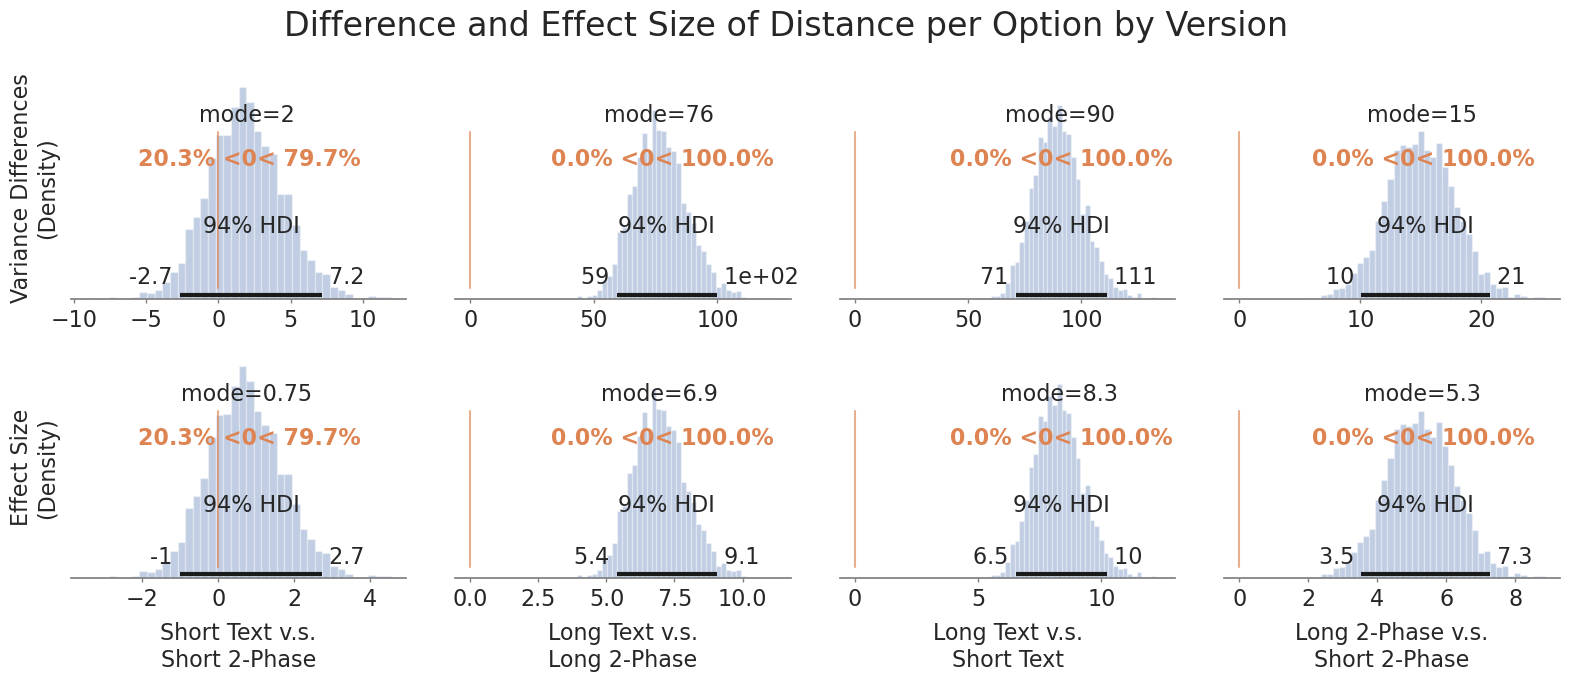

In [46]:
# Adjust plot design to match reference
fig, axes = plt.subplots(2, len(desired_order), figsize=(16, 7), sharey="row", constrained_layout=True)

# Define histogram bin size
bin_size = 40  # Updated to reflect more bins if desired

# Create plots for the first row (variance differences)
for i, label in enumerate(desired_order):
    az.plot_posterior(
        idata_var_diff,
        var_names=[label],
        ax=axes[0, i],
        hdi_prob=0.94,
        point_estimate="mode",
        ref_val=0,
        kind="hist",
        bins=bin_size,
        textsize=16,
    )
    # Style adjustments for titles and labels
    axes[0, i].set_title(f"", fontsize=0)
    axes[0, i].grid(axis="x", linestyle="", alpha=0.6)  # X-axis grid lines only
    axes[0, i].grid(axis="y", linestyle="", alpha=0.0)  # No Y-axis grid lines

# Create plots for the second row (effect sizes)
for i, label in enumerate(desired_order):
    az.plot_posterior(
        idata_effect_sizes,
        var_names=[label],
        ax=axes[1, i],
        hdi_prob=0.94,
        point_estimate="mode",
        ref_val=0,
        kind="hist",
        bins=bin_size,
        textsize=16,
    )
    axes[1, i].set_title("")
    axes[1, i].grid(axis="x", linestyle="", alpha=0.6)  # X-axis grid lines only
    axes[1, i].grid(axis="y", linestyle="", alpha=0.0)  # No Y-axis grid lines

# Adjust labels and layout
axes[0, 0].set_ylabel("Variance Differences\n(Density)", fontsize=16)
axes[1, 0].set_ylabel("Effect Size\n(Density)", fontsize=16)

# set the x-axis label for the last row of plots with the version names through order_label[label]
for i in range(len(desired_order)):
    axes[1, i].set_xlabel(order_label[desired_order[i]], fontsize=16)

# Add a plot-wide title
plt.suptitle(
    "Difference and Effect Size of Distance per Option by Version",
    fontsize=24,
    # y=1.05  # Position the title above the plots
)

# Adjust layout and display
plt.tight_layout()
plt.savefig(f'{path}/distance_diff_per_option_effect_size_by_version_all.pdf', format='pdf', bbox_inches='tight')
plt.show()

### Cumulative distance
Finally, we look at the cumulative distance traversed by participants for each option as function of slope indicating continuous increase in distance traversed by participants.

In [47]:
voting_combined_data.head(3)

,type,timestamp,time_diff,totalCursorDistance,totalMouseClicks,user_id,version_id,option_id,old_vote,new_vote,vote_diff,option_position,option_position_view,filled_page_action,version,old_group,new_group,card_order,new_position,old_position,raw_page_action,diff_square,num_groupings,distance_diff,abs_distance,cumulative_distance,cumulative_voting_time,cumulative_cursor_distance,cumsum_diff_square,step
0,options/updateOptionVotes,2023-09-30 21:31:30.090000+00:00,49.203,3596.028726,6,S003,v1,option_15,0.0,3.0,3.0,5.0,2.0,voting,v1_short_traditional,NaN,NaN,NaN,NaN,NaN,NaN,9.0,0,5.0,5.0,5.0,49.203,3596.028726,9.0,1
1,options/updateOptionVotes,2023-09-30 21:31:37.572000+00:00,7.482,391.227659,2,S003,v1,option_1,0.0,2.0,2.0,2.0,5.0,voting,v1_short_traditional,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0,-3.0,3.0,8.0,56.685,3987.256385,13.0,2
2,options/updateOptionVotes,2023-09-30 21:31:48.505000+00:00,10.933,245.090242,2,S003,v1,option_11,0.0,5.0,5.0,3.0,4.0,voting,v1_short_traditional,NaN,NaN,NaN,NaN,NaN,NaN,25.0,0,1.0,1.0,9.0,67.618,4232.346627,38.0,3


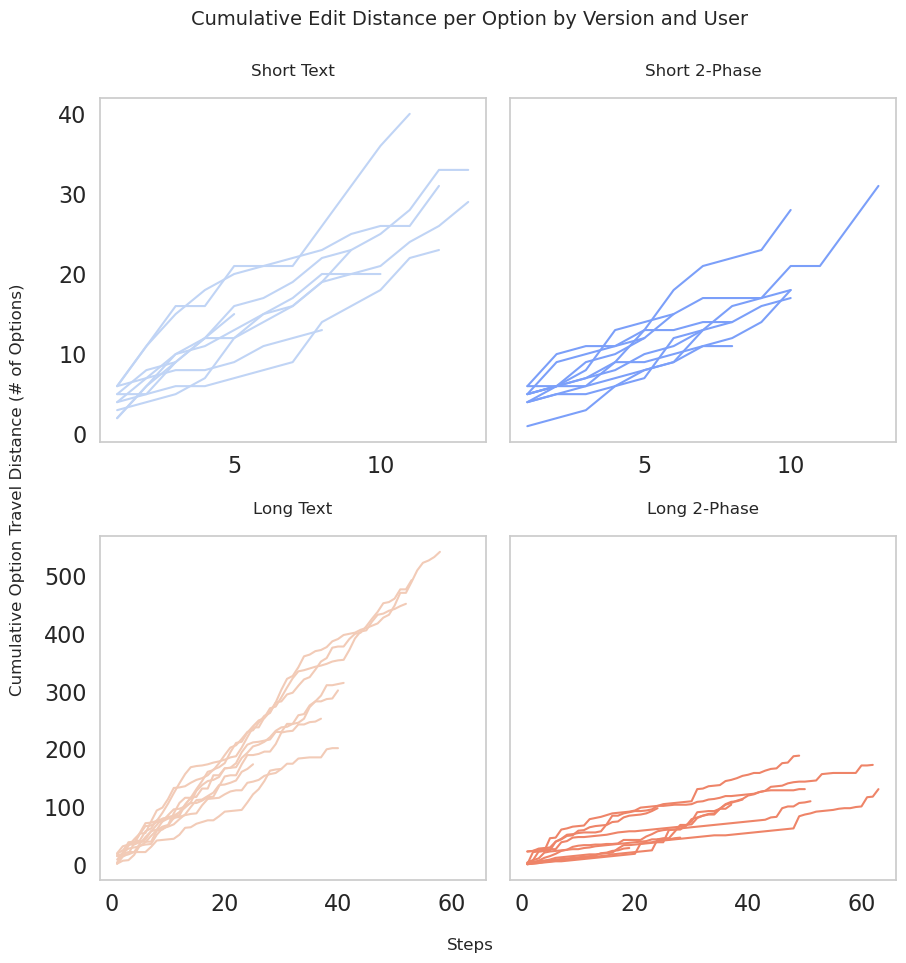

In [48]:
# Define color palette and mapping
palette = 'coolwarm'
colors = sns.color_palette(palette, 4)
color_map = {'v1': colors[1], 'v2': colors[0], 'v3': colors[2], 'v4': colors[3]}

# Create a copy of the data for this task
voting_combined_data_with_steps = voting_combined_data.copy()

# Create subplots for 2x2 layout
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10), sharex='row', sharey='row')

# Group version IDs into the two scale groups
scale_groups = {
    "v1_v2": ["v1", "v2"],
    "v3_v4": ["v3", "v4"]
}

# Plot for each scale group
for (scale_group, version_ids), ax_row in zip(scale_groups.items(), axes):
    for ax, version_id in zip(ax_row, version_ids):
        group_data = voting_combined_data_with_steps[voting_combined_data_with_steps["version_id"] == version_id]
        
        # Use a consistent color for all users in the same version
        color = color_map[version_id]
        
        # Plot each user's data with the assigned color
        for user_id, user_data in group_data.groupby("user_id"):
            ax.plot(
                user_data["step"],
                user_data["cumulative_distance"],
                label=user_id,
                # alpha=0.7,
                color=color  # Use color map
            )
        ax.set_title(plot_oneline_names[version_id], fontsize=12)  # Updated title
        ax.set_xlabel("")  # Hide individual x-axis labels

        #remove grid lines
        ax.grid(False)
        

# Add a shared y-axis label
fig.text(0.04, 0.5, "Cumulative Option Travel Distance (# of Options)", va='center', rotation='vertical', fontsize=12)

# Shared x-axis label
fig.text(0.5, 0.04, "Steps", ha='center', fontsize=12)

# Adjust layout
plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])  # Adjust layout for clarity

plt.suptitle("Cumulative Edit Distance per Option by Version and User", fontsize=14)

plt.savefig(f'{path}/cumulative_edit_distance_per_option_by_version_and_user.pdf', format='pdf', bbox_inches='tight')
plt.show()



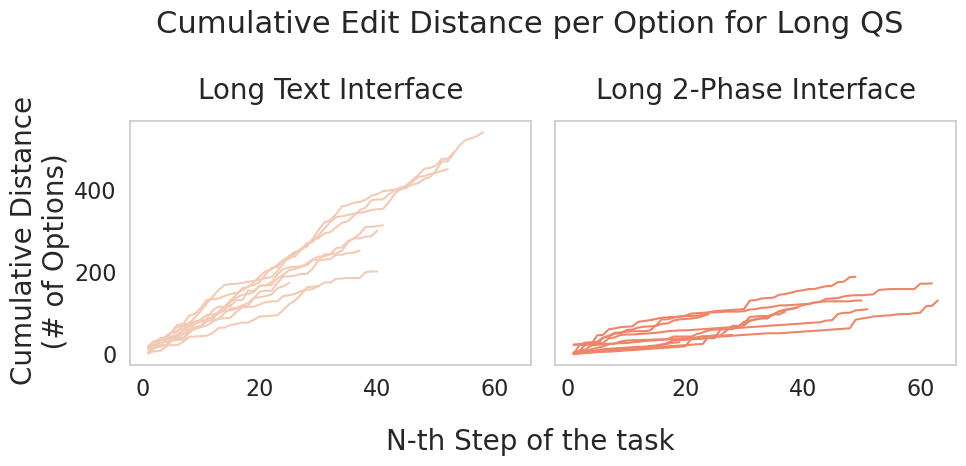

In [49]:
# Define color palette and mapping
palette = 'coolwarm'
colors = sns.color_palette(palette, 4)
color_map = {'v1': colors[1], 'v2': colors[0], 'v3': colors[2], 'v4': colors[3]}

# Define mapping for subplot titles
plot_oneline_names = {
    "v1": "Short Text Interface",
    "v2": "Short 2-Phase Interface",
    "v3": "Long Text Interface",
    "v4": "Long 2-Phase Interface"
}

# Create a copy of the data for this task
voting_combined_data_with_steps = voting_combined_data.copy()

# Create subplots for a single row layout
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharex=True, sharey=True)

# Define the versions to plot
versions_to_plot = ["v3", "v4"]

# Plot data for the specified versions
for ax, version_id in zip(axes, versions_to_plot):
    group_data = voting_combined_data_with_steps[voting_combined_data_with_steps["version_id"] == version_id]
    
    # Use a consistent color for all users in the same version
    color = color_map[version_id]
    
    # Plot each user's data with the assigned color
    for user_id, user_data in group_data.groupby("user_id"):
        ax.plot(
            user_data["step"],
            user_data["cumulative_distance"],
            label=user_id,
            # alpha=0.8,
            color=color  # Use color map
        )
    ax.set_title(plot_oneline_names[version_id], fontsize=20)  # Updated title
    ax.set_xlabel("")  # Hide individual x-axis labels
    
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)

    #remove grid lines
    ax.grid(False)

# Add a shared y-axis label
fig.text(-0.02, 0.42, "Cumulative Distance\n    (# of Options)", va='center', rotation='vertical', fontsize=20)
fig.text(0.5, 0, "N-th Step of the task", ha='center', fontsize=20)

# x y ticks font


# Add a plot-wide title and adjust spacing
plt.suptitle("Cumulative Edit Distance per Option for Long QS", fontsize=22, y=0.88)

# Adjust layout to control spacing
plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.90])  # Adjust layout to avoid overlapping
fig.subplots_adjust(left=0.1)  # Add space between the y-axis label and the first plot

# Display the plot
plt.savefig(f'{path}/cumulative_edit_distance_per_option_long_qs_v3v4.pdf', format='pdf', bbox_inches='tight')
# save as png
plt.savefig(f'{path}/cumulative_edit_distance_per_option_long_qs_v3v4.png', format='png', bbox_inches='tight')
plt.show()

In [50]:
v3_v4_data = voting_combined_data_with_steps[voting_combined_data_with_steps["version_id"].isin(["v3", "v4"])].copy()
v3_v4_data["user_idx"] = v3_v4_data["user_id"].astype("category").cat.codes
v3_v4_data["version_idx"] = v3_v4_data["version_id"].astype("category").cat.codes

In [51]:
# Prepare input variables for the Bayesian model
distance = jnp.array(v3_v4_data['cumulative_distance'], dtype=jnp.float32)
step = jnp.array(v3_v4_data['step'], dtype=jnp.int32)
user_idx = jnp.array(v3_v4_data['user_idx'], dtype=jnp.int32)
version_idx = jnp.array(v3_v4_data['version_idx'], dtype=jnp.int32)
stopping_step = jnp.array(
    v3_v4_data.groupby("user_id")["step"].max().reindex(v3_v4_data["user_id"]).values,
    dtype=jnp.int32
)

# Dimensions
n_users = v3_v4_data["user_id"].nunique()
n_versions = v3_v4_data["version_id"].nunique()
n_steps = v3_v4_data["step"].max()

print("Unique Users:", n_users)
print("Unique Versions:", n_versions)
print("Max Steps:", n_steps)
print("Distance Shape:", distance.shape)
print("Stopping Steps per User:", stopping_step.shape)
print("Version Index Shape:", version_idx.shape)
print("User Index Shape:", user_idx.shape)
print("Step Shape:", step.shape)


Unique Users: 20
Unique Versions: 2
Max Steps: 63
Distance Shape: (813,)
Stopping Steps per User: (813,)
Version Index Shape: (813,)
User Index Shape: (813,)
Step Shape: (813,)


In [52]:
def hierarchical_cumulative_model_with_partial_sharing(
    distance=None, 
    step=None, 
    user_idx=None, 
    version_idx=None, 
    n_users=None, 
    n_versions=None, 
    stopping_step=None,
    data_size=None
):
    # Shared intercept prior
    shared_intercept = numpyro.sample("shared_intercept", dist.Normal(2.0, 0.5))
    
    # Slope hierarchy priors
    slope_mean = numpyro.sample("slope_mean", dist.Normal(0.05, 0.05))
    slope_sd = numpyro.sample("slope_sd", dist.HalfNormal(0.1))
    
    # Non-centered parameterization for intercept deviations
    intercept_sd = numpyro.sample("intercept_sd", dist.HalfNormal(0.2))
    
    # Use expand for versions instead of plate
    intercept_raw = numpyro.sample(
        "intercept_raw",
        dist.Normal(0.0, 1.0).expand([n_versions]).to_event(1)
    )
    intercepts = shared_intercept + intercept_raw * intercept_sd
    
    slopes = numpyro.sample(
        "slopes",
        dist.Normal(slope_mean, slope_sd).expand([n_versions]).to_event(1)
    )
    
    # User-specific effects (additive) with tighter priors
    user_effect_sd = numpyro.sample("user_effect_sd", dist.HalfNormal(0.1))
    with numpyro.plate("users", n_users):
        user_effects = numpyro.sample("user_effects", dist.Normal(0.0, user_effect_sd))
    
    # Expected cumulative distance
    expected_cumulative = intercepts[version_idx] + slopes[version_idx] * step + user_effects[user_idx] * step

    # Mask likelihood for steps up to the stopping step
    active_mask = step <= stopping_step[user_idx]

    # Residual standard deviation
    residual_sd = numpyro.sample("residual_sd", dist.HalfNormal(0.3))

    if distance is not None:
        actual_data_size = distance.shape[0]
    else:
        actual_data_size = data_size
    
    # Likelihood using a Truncated Normal distribution (for observed data)
    with numpyro.plate("data", actual_data_size):
        numpyro.sample(
            "obs",
            dist.TruncatedNormal(
                loc=expected_cumulative,
                scale=residual_sd,
                low=0.0
            ).mask(active_mask),
            obs=distance
        )


# Prepare the data
# Assuming `v3_v4_data` is a pandas DataFrame with the necessary columns
import pandas as pd

# Example data preparation (replace with actual data)
# v3_v4_data = pd.read_csv("your_data.csv")  # Replace with your data loading method

distance = jnp.array(v3_v4_data['cumulative_distance'], dtype=jnp.float32)
step = jnp.array(v3_v4_data['step'], dtype=jnp.float32)
user_idx = jnp.array(v3_v4_data['user_idx'], dtype=jnp.int32)
version_idx = jnp.array(v3_v4_data['version_idx'], dtype=jnp.int32)
n_users = v3_v4_data['user_id'].nunique()
n_versions = v3_v4_data['version_id'].nunique()
stopping_step = jnp.array(
    v3_v4_data.groupby("user_id")["step"].max().reindex(v3_v4_data["user_id"]).values,
    dtype=jnp.int32
)

# Set up and run the MCMC
rng_key = jax.random.PRNGKey(0)
kernel = NUTS(hierarchical_cumulative_model_with_partial_sharing)
mcmc = MCMC(kernel, num_warmup=1500, num_samples=2000, num_chains=2)
mcmc.run(
    rng_key,
    distance=distance,
    step=step,
    user_idx=user_idx,
    version_idx=version_idx,
    n_users=n_users,
    n_versions=n_versions,
    stopping_step=stopping_step,
    data_size=None
)

# Print the summary of results
mcmc.print_summary()


/tmp/ipykernel_19343/159841759.py:86: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=1500, num_samples=2000, num_chains=2)
sample: 100%|██████████| 3500/3500 [00:16<00:00, 208.52it/s, 63 steps of size 7.01e-02. acc. prob=0.93] 



                        mean       std    median      5.0%     95.0%     n_eff     r_hat
  intercept_raw[0]      0.00      1.00      0.01     -1.55      1.70   4351.74      1.00
  intercept_raw[1]      0.97      1.13      0.99     -0.93      2.75   3797.68      1.00
      intercept_sd      0.24      0.17      0.22      0.00      0.48   2799.08      1.00
       residual_sd      7.26      0.12      7.26      7.07      7.46   4546.22      1.00
  shared_intercept      3.04      0.40      3.04      2.40      3.69   4673.94      1.00
        slope_mean      0.08      0.05      0.08     -0.00      0.16   4622.70      1.00
          slope_sd      0.86      0.05      0.86      0.78      0.94   2830.25      1.00
         slopes[0]      7.13      0.25      7.14      6.70      7.52    575.09      1.00
         slopes[1]      2.38      0.23      2.38      1.99      2.73    590.33      1.00
    user_effect_sd      0.73      0.05      0.73      0.64      0.81   2448.23      1.00
   user_effects[0]  

In [53]:
# -----------------------------
# Posterior Predictive Sampling
# -----------------------------

# Generate posterior predictive samples
# This step uses the posterior samples to generate predictions for 'obs'

# Step 1: Extract posterior samples
posterior_samples = mcmc.get_samples()

# Step 2: Define a Predictive object
predictive = Predictive(
    hierarchical_cumulative_model_with_partial_sharing,
    posterior_samples=posterior_samples,
    num_samples=4000,  # Number of predictive samples per posterior sample
    return_sites=["obs"]
)

# Step 3: Generate predictions
# Use the same data as the observed data
# If you have new data for prediction, replace the arguments accordingly
rng_key_predict = jax.random.PRNGKey(1)
predictions = predictive(
    rng_key_predict,
    distance=None,  # Set to None for prediction
    step=step,
    user_idx=user_idx,
    version_idx=version_idx,
    n_users=n_users,
    n_versions=n_versions,
    stopping_step=stopping_step,
    data_size=step.shape[0]  # Explicitly pass the data size
)

# Step 4: Extract predicted distances
predicted_distances = predictions["obs"]

# Now, 'predicted_distances' has the correct shape


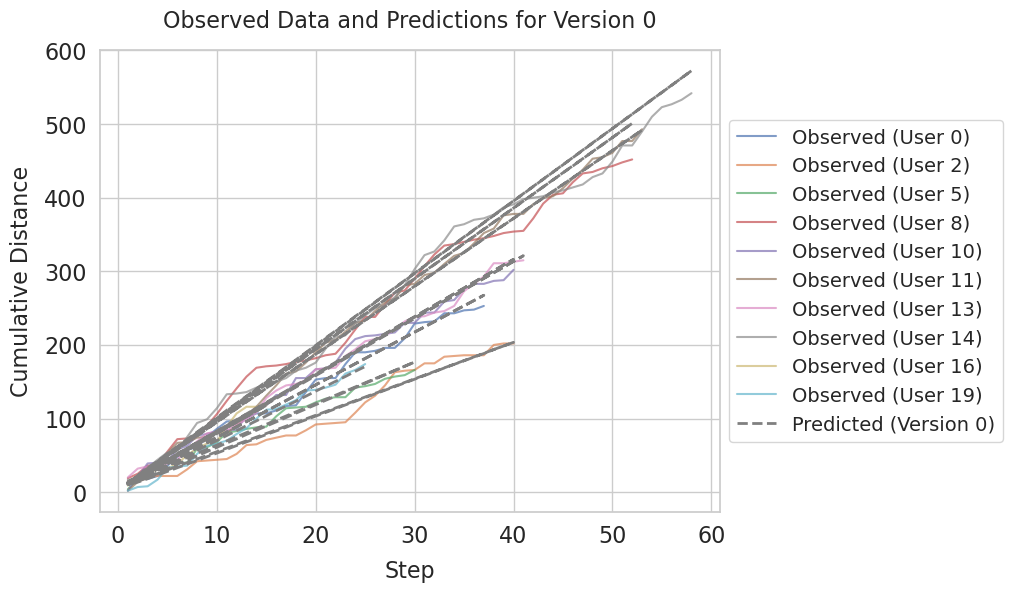

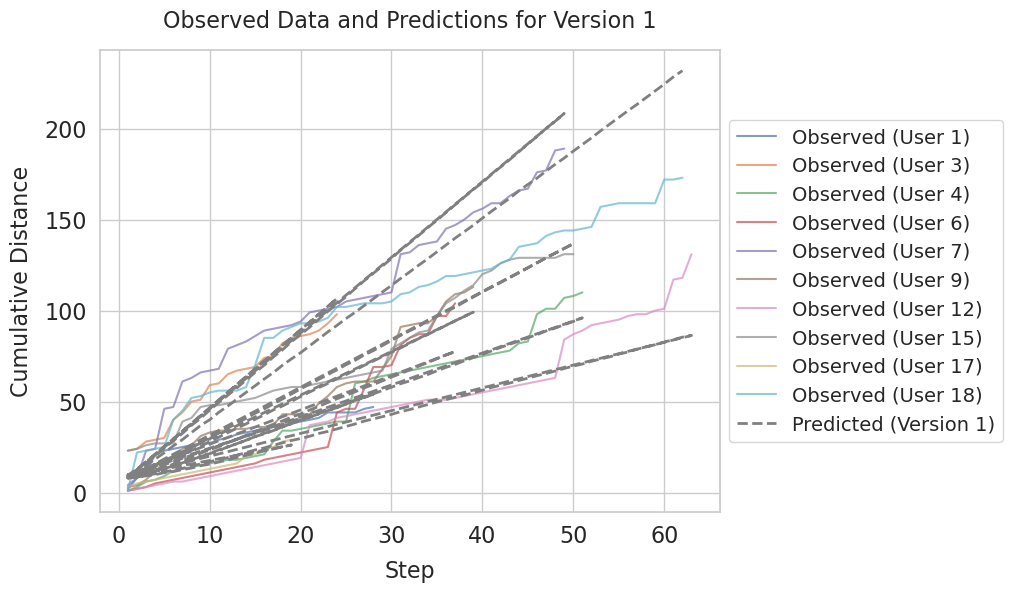

In [54]:
# Compute mean and credible intervals for predicted distances
mean_predictions = np.mean(predicted_distances, axis=0)  # Mean across posterior samples
lower_bound = np.percentile(predicted_distances, 2.5, axis=0)  # 2.5% credible interval
upper_bound = np.percentile(predicted_distances, 97.5, axis=0)  # 97.5% credible interval

# Get unique versions
unique_versions = np.unique(version_idx)

# Generate separate plots for each version
for version in unique_versions:
    plt.figure(figsize=(8, 6))
    
    # Mask for the current version
    version_mask = version_idx == version
    
    # Plot observed data for the current version
    for user in np.unique(user_idx[version_mask]):
        user_mask = (user_idx == user) & version_mask
        plt.plot(step[user_mask], distance[user_mask], label=f"Observed (User {user})", alpha=0.7)
    
    # Overlay regression line with credible intervals
    plt.plot(
        step[version_mask],
        mean_predictions[version_mask],
        label=f"Predicted (Version {version})",
        linestyle="--",
        linewidth=2,
        color="grey",
    )
    # plt.fill_between(
    #     step[version_mask],
    #     lower_bound[version_mask],
    #     upper_bound[version_mask],
    #     alpha=0.2,
    #     color="grey",
    #     label=f"95% CI (Version {version})",
    # )
    
    # Add labels, legend, and title
    plt.xlabel("Step")
    plt.ylabel("Cumulative Distance")
    plt.title(f"Observed Data and Predictions for Version {version}")
    plt.legend()
    # legend  outside the plot
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()


In [55]:
posterior_samples = mcmc.get_samples()

unique_versions = np.unique(version_idx)

# Calculate median stopping steps for each version
median_stopping_steps = []
for version in unique_versions:
    # Get stopping steps for the current version
    version_steps = stopping_step[version_idx == version]
    # Compute median
    median_step = np.median(version_steps)
    median_stopping_steps.append(median_step)

# Convert to numpy array for easier use later
median_stopping_steps = np.array(median_stopping_steps)

posterior_predictions = {}
for version in unique_versions:
    # Get steps up to the median stopping point for this version
    steps = np.arange(1, int(median_stopping_steps[version]) + 1)
    version_predictions = []
    for i in range(len(posterior_samples["shared_intercept"])):  # Use posterior_samples
        # Compute intercept and slope for this version
        intercept = (
            posterior_samples["shared_intercept"][i]
            + posterior_samples["intercept_raw"][i, version]
            * posterior_samples["intercept_sd"][i]
        )
        slope = posterior_samples["slopes"][i, version]
        residual_sd = posterior_samples["residual_sd"][i]
        
        # Expected cumulative distance
        expected_cumulative = intercept + slope * steps
        
        # Sample distances (apply truncation)
        sampled_distances = np.random.normal(expected_cumulative, residual_sd)
        sampled_distances = np.maximum(sampled_distances, 0)
        version_predictions.append(sampled_distances)
    
    posterior_predictions[version] = np.array(version_predictions)


In [56]:
# Summarize posterior predictions
posterior_summary = {}
for version in unique_versions:
    predictions = posterior_predictions[version]
    posterior_summary[version] = {
        "mean": predictions.mean(axis=0),
        "lower": np.percentile(predictions, 5, axis=0),
        "upper": np.percentile(predictions, 95, axis=0),
        "steps": np.arange(1, int(median_stopping_steps[version]) + 1)
    }

[(0.42852192568663816, 0.6022859457022, 0.7307907632583843),
 (0.9020198584978432, 0.5835085280732535, 0.6070382118908446)]

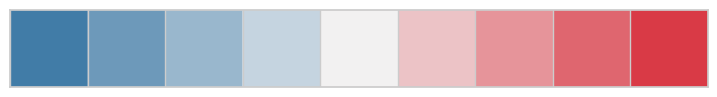

In [57]:
colors_exp = sns.palplot(sns.diverging_palette(240, 10, n=9))
# get the third color
c1 = color_exp = sns.diverging_palette(240, 10, n=9)[1]
c2 = color_exp = sns.diverging_palette(240, 10, n=9)[6]
sns.color_palette([c1, c2])

In [58]:
palette = 'coolwarm'
colors = sns.color_palette(palette, 4)
color_map = {'v1': colors[1], 'v2': colors[0], 'v3': colors[2], 'v4': colors[3]}
sns.color_palette([colors[1], colors[0], colors[2], colors[3]])

[(0.753610618, 0.830232851, 0.960871157),
 (0.48385432959999997, 0.6220498496, 0.9748082026),
 (0.9473454036, 0.7946955048, 0.7169905058),
 (0.9318312966, 0.5190855232, 0.4064796086)]

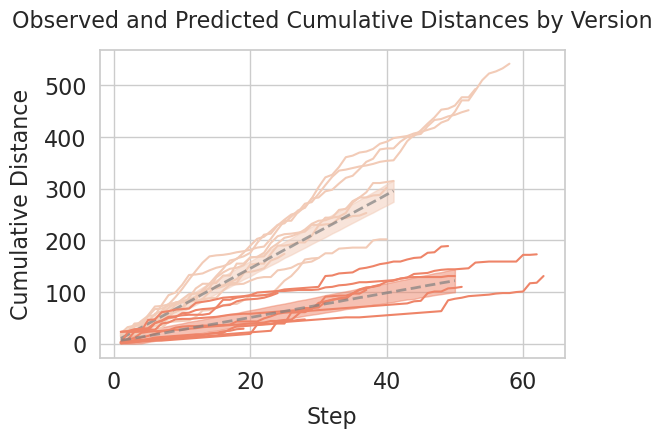

In [59]:
# Generate a single plot
plt.figure(figsize=(6, 4))

colors = [colors[2], colors[3]]  # One color per version

for version in unique_versions:
    # Mask for the current version
    version_mask = version_idx == version

    # Plot observed data for all users in the current version
    for user in np.unique(user_idx[version_mask]):
        user_mask = (user_idx == user) & version_mask
        plt.plot(
            step[user_mask],
            distance[user_mask],
            label=f"Observed (User {user}, Version {version})",
            alpha=1,
            color=colors[version]
        )

    # Add posterior predictive regression line with credible intervals
    summary = posterior_summary[version]
    plt.plot(
        summary["steps"],
        summary["mean"],
        label=f"Predicted (Version {version})",
        linestyle="--",
        linewidth=2,
        color='gray',
        alpha=0.7
    )
    plt.fill_between(
        summary["steps"],
        summary["lower"],
        summary["upper"],
        alpha=0.5,
        color=colors[version],
        label=f"95% CI (Version {version})"
    )

# Add labels, legend, and title
plt.xlabel("Step")
plt.ylabel("Cumulative Distance")
plt.title("Observed and Predicted Cumulative Distances by Version")
# plt.legend(loc="left")
plt.savefig(f'{path}/observed_and_predicted_cumulative_distances_by_version_m3.pdf', format='pdf', bbox_inches='tight')
plt.show()


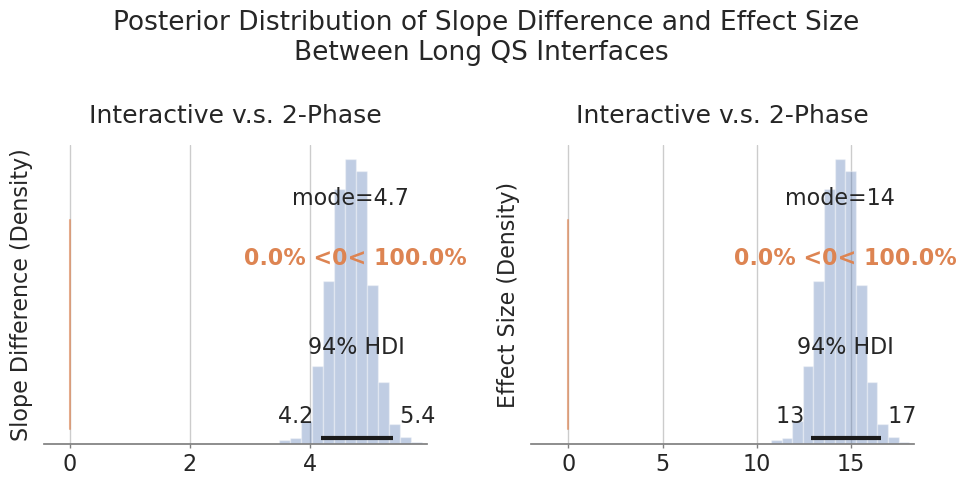

In [60]:
# Assuming MCMC has already been run
posterior_samples = mcmc.get_samples()  # Retrieve posterior samples

# Extract posterior samples for slopes
slopes_v0 = posterior_samples["slopes"][:, 0]  # Slopes for version 0
slopes_v1 = posterior_samples["slopes"][:, 1]  # Slopes for version 1

# Calculate slope differences (effect size)
slope_diff = slopes_v0 - slopes_v1  # V0 - V1 to ensure positive values
effect_size = slope_diff / np.std(slope_diff)  # Standardized effect size

# Convert slope differences and effect sizes into ArviZ InferenceData
idata_diff = az.convert_to_inference_data({
    "slope_diff": slope_diff,
    "effect_size": effect_size,
})

# Plot posterior distributions side-by-side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot posterior distribution for the slope difference
az.plot_posterior(
    idata_diff,
    var_names=["slope_diff"],
    hdi_prob=0.94,  # 94% HDI
    kind="hist",  # Histogram representation
    point_estimate="mode",  # Use mean for central tendency
    ref_val=0,  # Add reference line at 0
    round_to=2,
    ax=axes[0],
    textsize=16,
)
axes[0].set_xlim(slope_diff.min()-4, slope_diff.max())

# Customize the first plot
axes[0].set_title("Interactive v.s. 2-Phase", fontsize=18)
axes[0].set_ylabel("Slope Difference (Density)", fontsize=16)

# Plot posterior distribution for the effect size
az.plot_posterior(
    idata_diff,
    var_names=["effect_size"],
    hdi_prob=0.94,  # 94% HDI
    kind="hist",  # Histogram representation
    point_estimate="mode",  # Use mean for central tendency
    ref_val=0,  # Add reference line at 0
    round_to=2,
    ax=axes[1],
    textsize=16,
)

axes[1].set_xlim(effect_size.min() - 13, effect_size.max())

# Customize the second plot
axes[1].set_title("Interactive v.s. 2-Phase", fontsize=18)
axes[1].set_ylabel("Effect Size (Density)", fontsize=16)

# set plt title
plt.suptitle("Posterior Distribution of Slope Difference and Effect Size\nBetween Long QS Interfaces ", fontsize=19)

# Adjust layout and display
plt.tight_layout()
plt.savefig(f'{path}/slope_diff_and_effect_size.pdf', format='pdf', bbox_inches='tight')
plt.show()